# Using the wombats Wrapper for Minigrid Gym Environments

In [1]:
from wombats.systems import (StaticMinigridTSWrapper,
                             LavaComparison_noDryingOff)
from wombats.automaton import active_automata
from wombats.automaton import MinigridTransitionSystem
import gym

## Creating the Environment

We start by creating a gym environment (can be wrapped):

In [2]:
# ENV_ID = 'MiniGrid-LavaComparison_noDryingOff-v0'
# ENV_ID = 'MiniGrid-DistShift1-v0'
ENV_ID = 'MiniGrid-LavaGapS5-v0'
env = gym.make(ENV_ID)

Now that we have a regular Minigrid environment, we can wrap it with the wombats® minigrid wrapper to extract the abstraction of the environment.

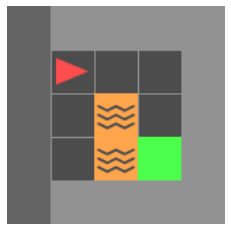

In [3]:
env = StaticMinigridTSWrapper(env)
env.reset()
env.render_notebook()

## Creating the Transition System Representation

Now that we have wrapped the environemt in our wrapper, we can build a transition system out of the wrapped minigrid environment.

Note that the TS and the Minigrid environment will be kept in sync

In [4]:
minigrid_TS = active_automata.get(automaton_type='TS', graph_data=env,
                                  graph_data_format='minigrid')

Now that we created a transition system representation for the Minigrid env, we can visualize the underlying transition system. **WARNING: the transition system will be too large to draw for most grid environments of any reasonable size.**

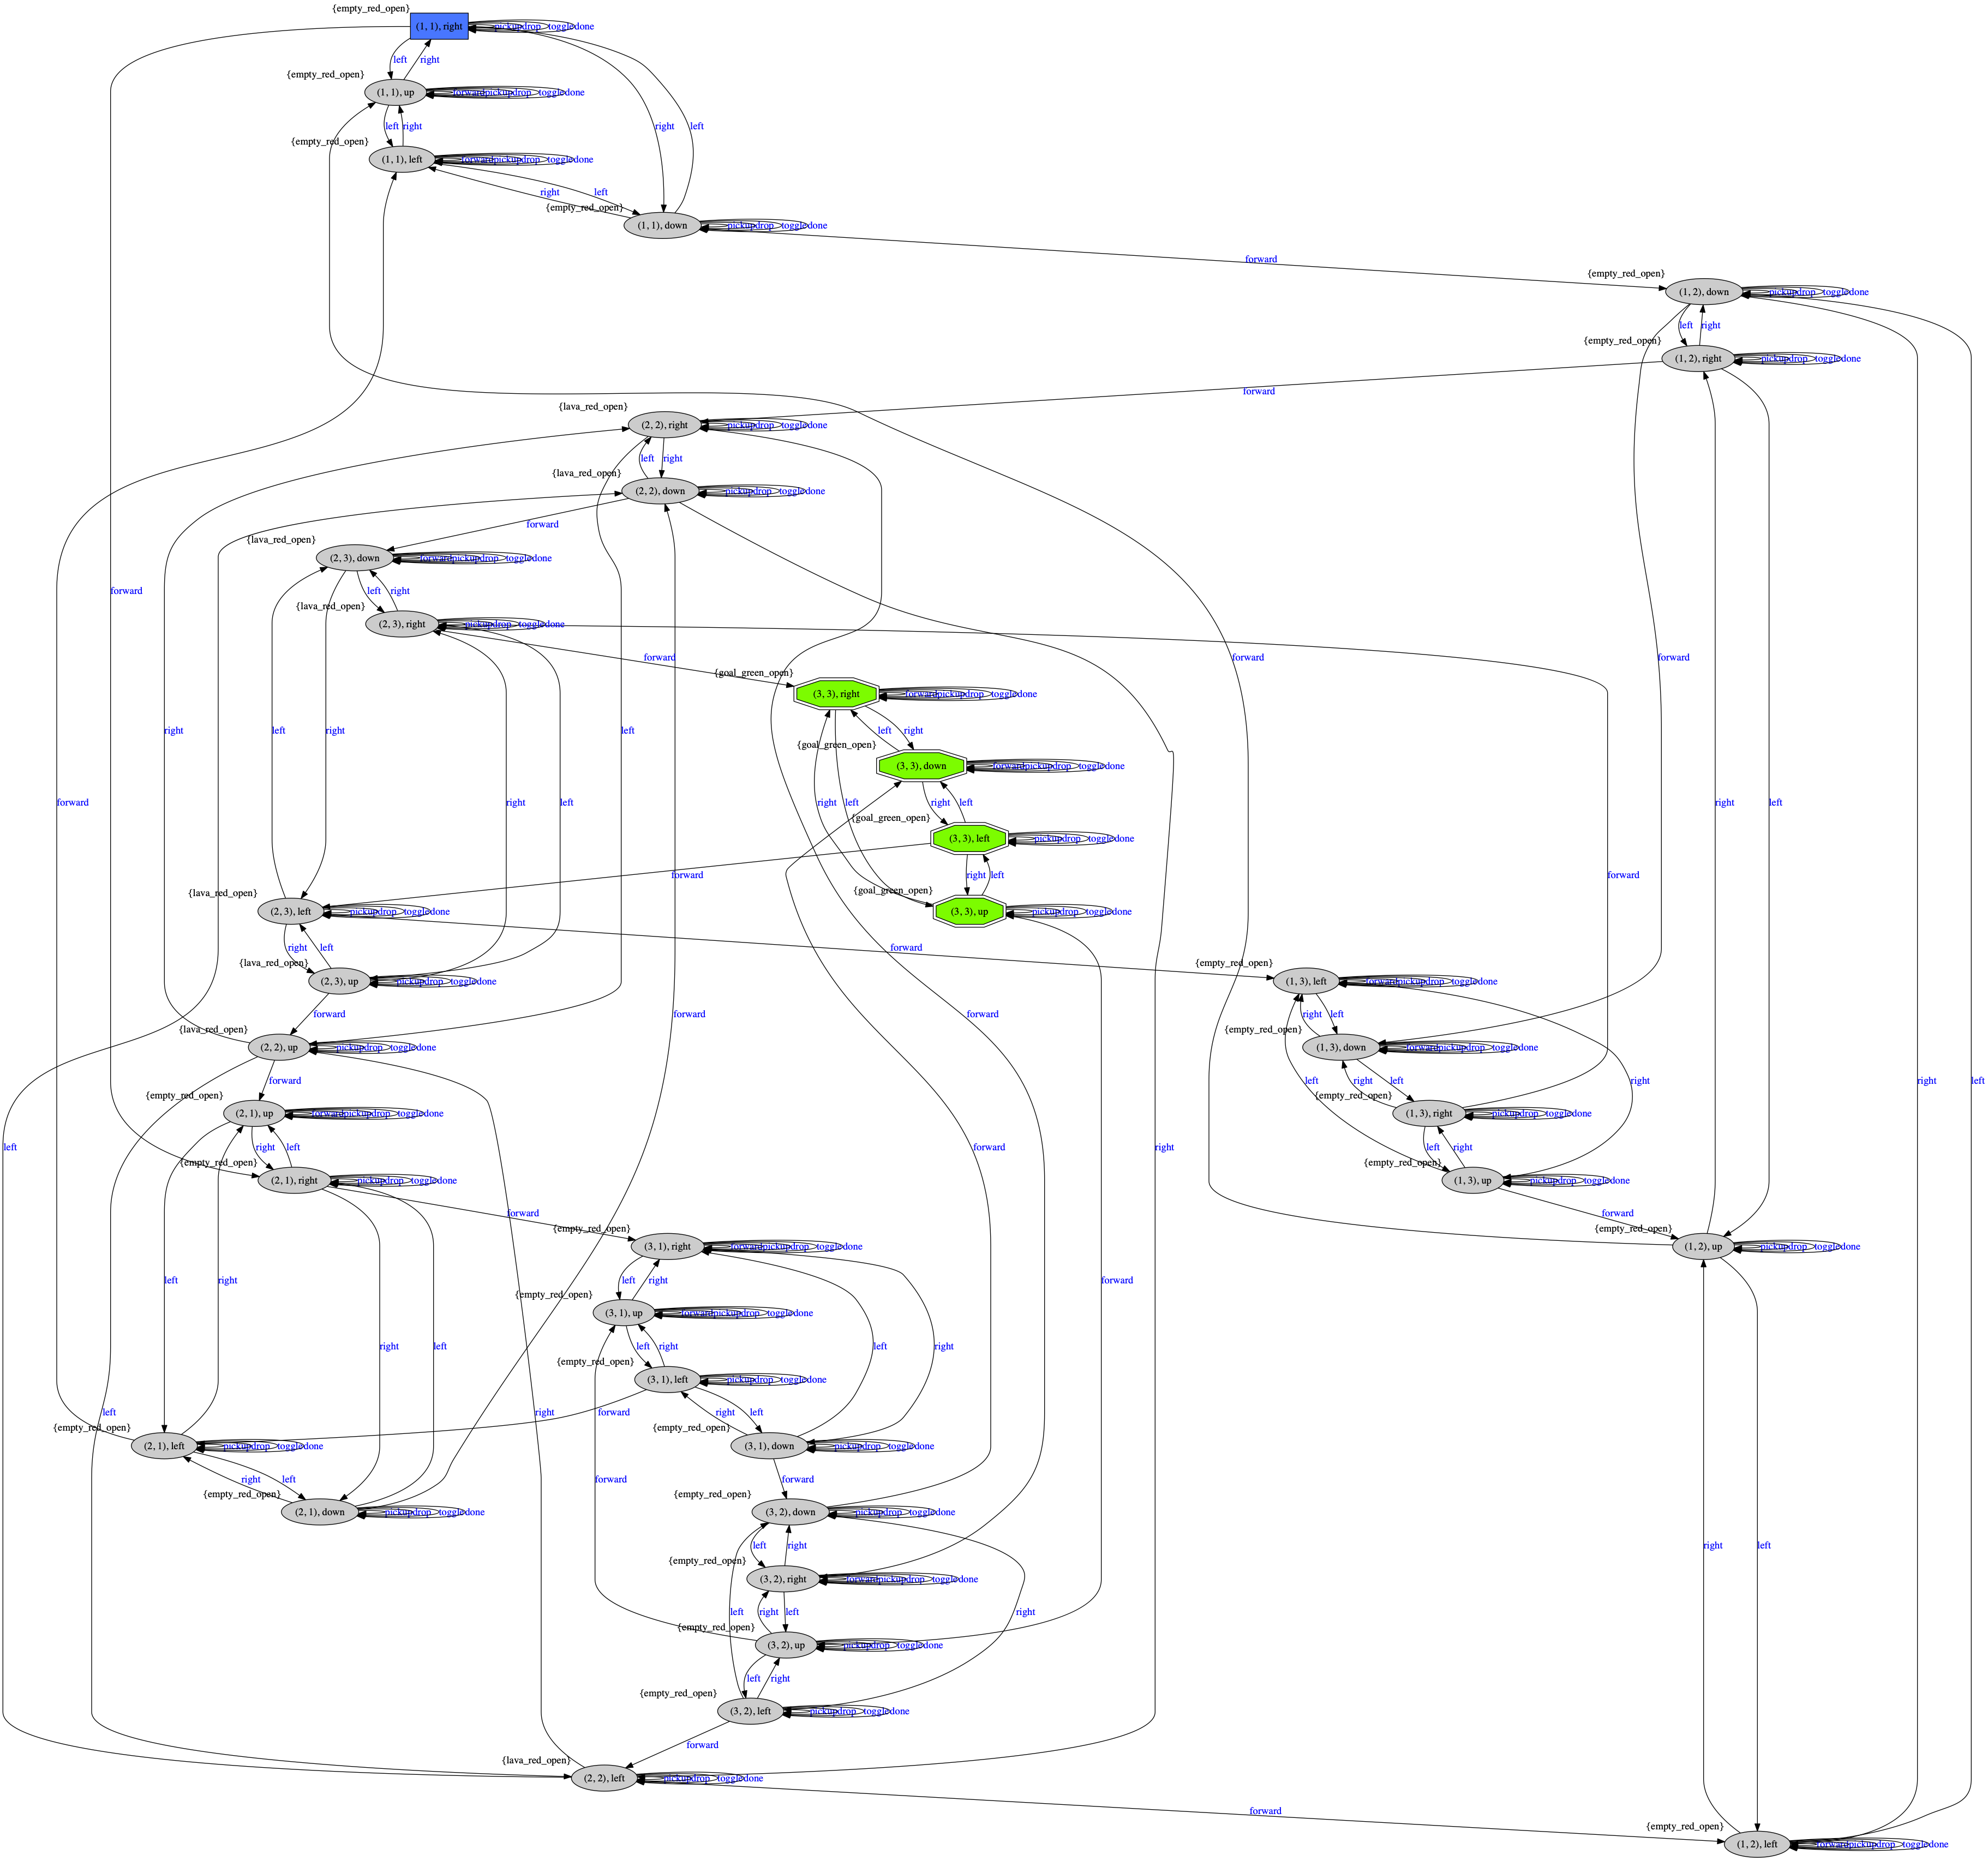

In [5]:
minigrid_TS.draw('_'.join([ENV_ID, 'TS']))

### Using the Transition System Representation

We can feed an environment action into the transition system and make the step in both the transition system and the gym environment:

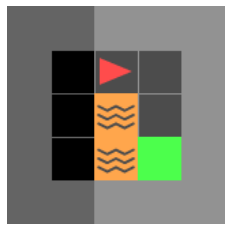

('(2, 1), right', 'empty_red_open')

In [6]:
actions = minigrid_TS.actions
minigrid_TS.transition(minigrid_TS.current_state, actions.forward,
                       show_steps=True)

or we feed the TS one of its symbols and make a step in both the transition system and the gym environment:

In [7]:
minigrid_TS.symbols

{'done', 'drop', 'forward', 'left', 'pickup', 'right', 'toggle'}

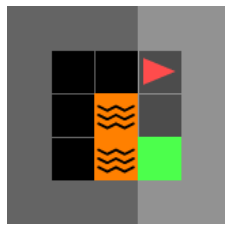

('(3, 1), right', 'empty_red_open')

In [8]:
minigrid_TS.transition(minigrid_TS.current_state, input_symbol='forward',
                       show_steps=True)

We can also compute a run on the TS, again using either `env` actions or TS symbols, to compute an output string and the sequence of visited states:

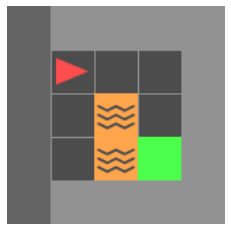

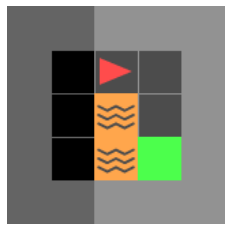

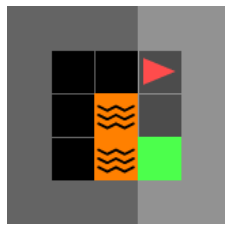

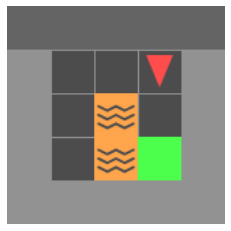

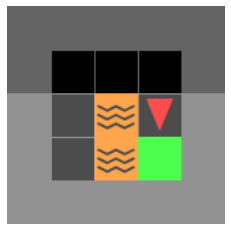

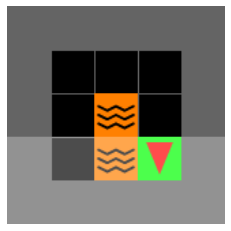

['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'goal_green_open'] ['(1, 1), right', '(2, 1), right', '(3, 1), right', '(3, 1), down', '(3, 2), down', '(3, 3), down']


In [11]:
controls = [actions.forward, actions.forward, actions.right,
            actions.forward, actions.forward]

output_string, visited_states = minigrid_TS.run(controls, show_steps=True)
print(output_string, visited_states)